<a href="https://colab.research.google.com/github/Ravivardhan/100MLProjects/blob/master/Copy_of_123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Dense

# New Section

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:

from google.colab import drive
drive.mount('/content/drive/MyDrive/weather_images.zip')

ValueError: ignored

In [11]:
path = '/'
path_imgs = list(glob.glob(path+'/**/*.jpg'))

In [12]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

<ipython-input-12-1c8a9373c5d6>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  file_path = pd.Series(path_imgs, name='File_Path').astype(str)
<ipython-input-12-1c8a9373c5d6>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  labels = pd.Series(labels, name='Labels')


,File_Path,Labels


# New Section

# New Section

KeyError: ignored

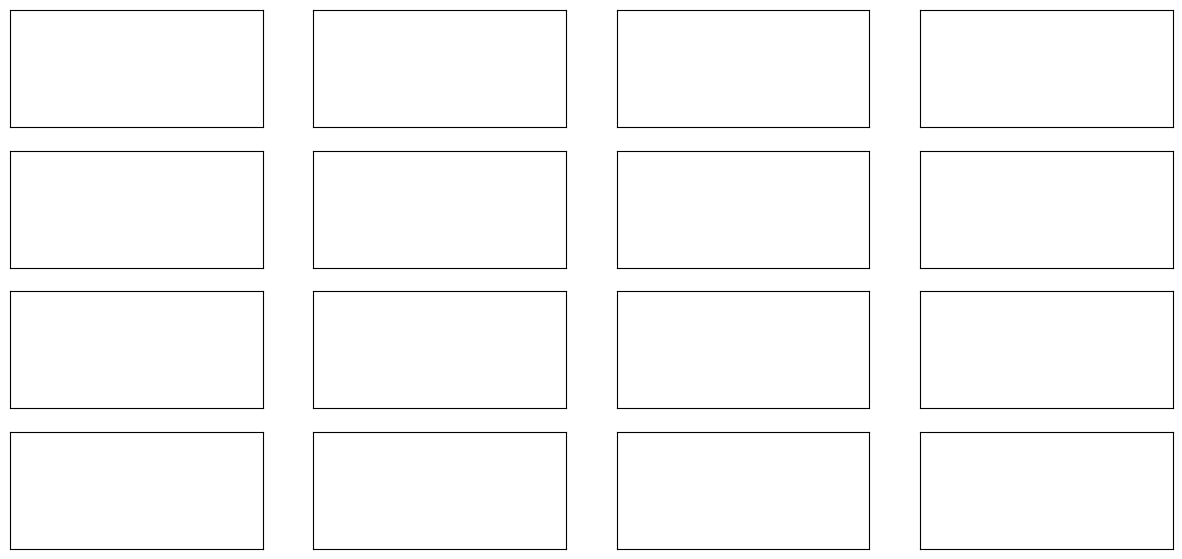

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

In [ ]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

In [ ]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

In [ ]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer= keras.optimizers.RMSprop(learning_rate = .00001),metrics=['accuracy'])
    
    return model

In [ ]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [ ]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model =func(MobileNet)
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=50,
    verbose=1
)
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

In [ ]:
#Code Example
#Import the module
import pickle
with open('fitted_model.pickle','wb') as modelFile:
     pickle.dump(history,modelFile)

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model =func(MobileNet)
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    verbose=1
)
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

In [ ]:
import pickle
with open('weather_100.pickle','wb') as modelFile:
     pickle.dump(history,modelFile)

In [ ]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],)
    
    return model



from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model =func(MobileNet)
history_adam = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=50,
    verbose=1
)



In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_adam.history['categorical_accuracy'])
plt.plot(history_adam.history['val_categorical_accuracy'])
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Train_adam','Test_adam'], loc='best')
plt.show()
#loss
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Train_adam','Test_adam'], loc='best')
plt.show()

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

In [ ]:
#WITH NO LEARNING RATE

In [ ]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])
    
    return model



from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model =func(MobileNet)
history_adam = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=50,
    verbose=1
)



In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_adam.history['categorical_accuracy'])
plt.plot(history_adam.history['val_categorical_accuracy'])
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Train_adam','Test_adam'], loc='best')
plt.show()
#loss
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Train_adam','Test_adam'], loc='best')
plt.show()

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

In [ ]:
#resnet50_epoch=50
def func1(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer= keras.optimizers.RMSprop(learning_rate = .00001),metrics=['accuracy'])
    
    return model


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet_pre=preprocess_input
train_gen_ResNet, valid_gen_ResNet, test_gen_ResNet = gen(ResNet_pre,train_df,test_df)
ResNet_model=func1(ResNet50)
filepath = '/content/drive/MyDrive/weather_pickle/resnet_model_50epoch.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]
resnet_history = ResNet_model.fit(
    train_gen_ResNet,
    validation_data=valid_gen_ResNet,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)
with open('/content/drive/MyDrive/weather_pickle/RMSprop/Resnet50_history_50epoch', 'wb') as file_pi:
  pickle.dump(resnet_history.history, file_pi)
with open('/content/drive/MyDrive/weather_pickle/RMSprop/Resnet50_predict_50epoch', 'wb') as modelfile:
  pickle.dump(ResNet_model, modelfile)

np.save('/content/drive/MyDrive/weather_pickle/RMSprop/Resnet50_history_50epoch.npy',resnet_history.history)
history_MobileNet = plot(resnet_history,test_gen_ResNet,train_gen_ResNet, ResNet_model)


result_ResNet = result_test(test_gen_ResNet,ResNet_model)

In [ ]:
#RESNET WITH 50EPOCH
import pickle
with open('/content/drive/MyDrive/weather_pickle/RMSprop/Resnet50_history_50epoch', 'wb') as file_pi:
  pickle.dump(resnet_history.history, file_pi)
with open('/content/drive/MyDrive/weather_pickle/RMSprop/Resnet50_predict_50epoch', 'wb') as modelfile:
  pickle.dump(ResNet_model, modelfile)

np.save('/content/drive/MyDrive/weather_pickle/RMSprop/Resnet50_history_50epoch.npy',resnet_history.history)
history_MobileNet = plot(resnet_history,test_gen_ResNet,train_gen_ResNet, ResNet_model)


result_ResNet = result_test(test_gen_ResNet,ResNet_model)